# Fitting a multimodal beta distribution

Can we generate and then fit a multimodal distribution with gradient descent?

Outline:
*   Generate random multimodal data
*   Use a Bernouli trial to suggest which beta distribution to sample from
*   Fit with gradient descent via PyTorch

## Generate random data

I'll make random data from two beta distributions and then select from them randomly to get two peaks.
I'll deliberately make the distributions fairly distinct to make the initial analysis easier to visualise.

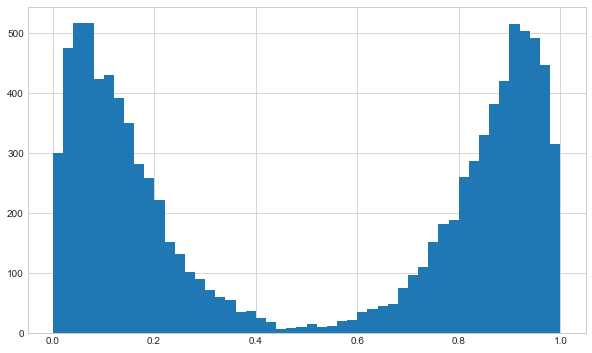

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

# true distribution parameters
p_d1 = 0.5
b1_param = (10, 1.5)
b2_param = (1.5, 10)

n = 10000
rand_gen = np.random.default_rng(seed=0)

mix_samples = rand_gen.binomial(n=1, p=p_d1, size=(n, 1))
b1_samples = rand_gen.beta(a=b1_param[0], b=b1_param[1], size=(n, 1))
b2_samples = rand_gen.beta(a=b2_param[0], b=b2_param[1], size=(n, 1))

rand_samples = mix_samples * b1_samples + (1 - mix_samples) * b2_samples

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rand_samples, bins=50)
plt.show()


## Creating a PyTorch model

Assuming we know the underlying generating model (...strong assumption...?), we can construct a network that builds the equivalent distribution objects in PyTorch.

We are fitting the distribution parameters.
As such we have no input features for the forward pass, only the output values.
We use negative log likelihood as the loss function to optimise.

In [2]:
import pytorch_lightning as pl
import torch


class BetaMixModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate=1e-3,
    ):
        super().__init__()

        self.beta_1_params = torch.nn.Parameter(torch.randn((2)))
        self.beta_2_params = torch.nn.Parameter(torch.randn((2)))
        self.beta_params = torch.nn.Parameter(torch.randn((2, 2)))
        self.mixture_prob = torch.nn.Parameter(torch.randn((2)))

        self.train_log_error = []
        self.val_log_error = []
        self.learning_rate = learning_rate

    def forward(self):
        # ensure correct domain for params
        beta_params_norm = torch.nn.functional.softplus(self.beta_params)
        mixture_prob_norm = torch.nn.functional.softmax(self.mixture_prob, dim=0)

        mix = torch.distributions.Categorical(mixture_prob_norm)
        comp = torch.distributions.Beta(beta_params_norm[:, 0], beta_params_norm[:, 1])
        mixture_dist = torch.distributions.MixtureSameFamily(mix, comp)

        return mixture_dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        return loss


I've noticed that training can get stuck in a local minima of loss -0.1.
Here I'm setting the seed before I create the model, to get a set of initial parameters which converge correctly.
This may suggest that the loss surface we are optimising is not too smooth.
Ideally I would train the network multiple times from random starting weights to investigate.

In [3]:
# create model
torch.manual_seed(1)
model = BetaMixModel(learning_rate=1e-0)

Now we can generate distribution objects from the model by calling the forward pass method.

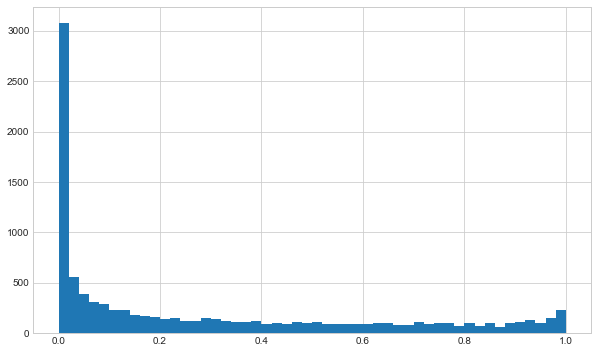

In [4]:
# get some samples
output_dist = model()
output_samples = output_dist.sample((n,1)).numpy()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(output_samples, bins=50)
plt.show()

## Fitting the model distribution
To train the model with our random sample data created above, we need to setup a dataloader to pass to the trainer.

In [5]:
# training on the whole dataset each batch
from torch.utils.data import TensorDataset, DataLoader

rand_samples_t = torch.Tensor(rand_samples)

dataset_train = TensorDataset(rand_samples_t)
dataloader_train = DataLoader(dataset_train, batch_size=len(rand_samples))

rand_samples_batch = next(iter(dataloader_train))
rand_samples_batch[0].shape

torch.Size([10000, 1])

Now we can train the model via PyTorch Lightning's Trainer object.

In [6]:
# fit network
trainer = pl.Trainer(
    max_epochs=100,
)
trainer.fit(model, dataloader_train)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
Missing logger folder: /Users/Rich/Developer/Github/VariousDataAnalysis/PyTorchStuff/fitting_multimodal_distributions/lightning_logs

  | Name | Type | Params
------------------------------
------------------------------
10        Trainable params
0         Non-trainable params
10        Total params
0.000     Total estimated model params size (MB)
/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which ma

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.39it/s, loss=-0.414, v_num=0]  


We can see the training loss has converged ok.

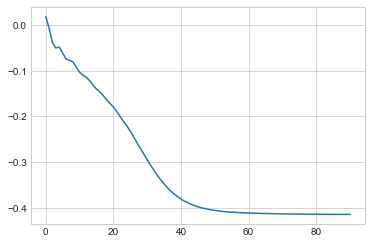

In [7]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


plt.plot(moving_average(np.array(model.train_log_error)))


## Checking results
Now we can check the resulting distribution that comes out of our model and compare that directly to the random samples.

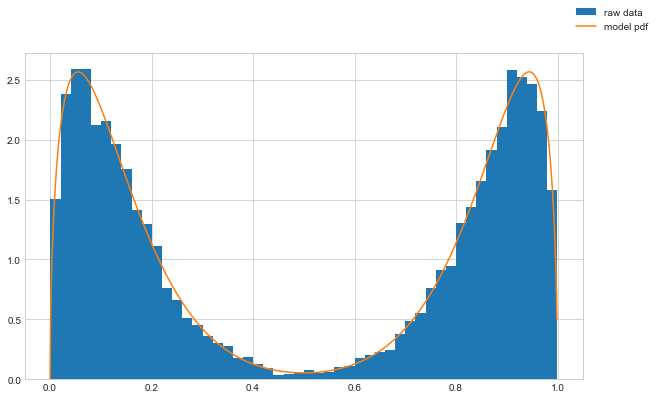

In [8]:
# plot pdf
output_dist = model()
x = torch.arange(0,1,0.001)
y = torch.exp(output_dist.log_prob(x))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rand_samples, bins=50, density=True, label='raw data')
ax.plot(x.detach().numpy(), y.detach().numpy(), label='model pdf')
fig.legend()
plt.show()

We can see that the trained distribution parameters now are close to the underlying parameters.

In [9]:
beta_params_norm = torch.nn.functional.softplus(model.beta_params).detach()
mixture_prob_norm = torch.nn.functional.softmax(model.mixture_prob, dim=0).detach()

print(beta_params_norm)
print(mixture_prob_norm)

tensor([[ 1.5257,  9.9830],
        [10.0109,  1.5317]])
tensor([0.4997, 0.5003])


```
b2_param = (1.5, 10)
b1_param = (10, 1.5)
p_d1 = 0.5
```

So seems successful overall!

Pros:

*   This approach makes it quite easy to train fairly complex distributions without having to understand the particular methods for that distribution type
*   Specific fitting procedures may not even exist for many complex distributions

Cons:

*   Potential for non-converging solutions
*   Time required to fit being probably slower than direct methods

Would be interesting to see how well MCMC does with this sort of problem... maybe next time.